# Homework 1

## BUSN 41204 - 2023

* Aman Krishna
* Christian Pavilanis
* Jingwen Li
* Yazmin Ramirez Delgado

In [1]:
import os
import pandas as pd
pd.set_option("display.precision", 4)
import numpy as np
from datetime import datetime
from datetime import timedelta
from matplotlib import pyplot as plt
import functools
from scipy import stats
import seaborn as sns
from sklearn.model_selection import LeavePOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols
import scipy as sp
import plotnine as p9
from sklearn.tree import DecisionTreeClassifier 
import random 
import math
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
import statsmodels.api as sm
pd.options.display.float_format = '{:.4f}'.format
pd.options.mode.chained_assignment = None  # default='warn'
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

### Q1.1
For each one the ten statements below say whether they are true or not and explain why.
#### 1. As one increases k, the number of nearest neighbor, in a kNN classifier, <br>
- (a) the bias of the classifier will increase; <br>
  - **True,** as the number of nearest neighbors increases, the bias of the classifier will increase. This is because the classifier will be more likely to be influenced by outliers. <br>
- (b) the variance of the classifier will increase; <br>
  - **False**, with higher k, the model complexity will be lower (due to reduced degrees of freedom), hence the variance should be low.  <br>
- (c) the misclassification rate on the training dataset will increase; <br>
  - **True**, as the number of nearest neighbors increases, the error on the training set increases to farther and farther points contributing to the error. We see that increasing K increases our error rate on the training set, because we are over-smoothing.  <br>
- (d) the misclassification rate on a test dataset will increase. <br>
  - **False**, For a test dataset, the misclassification rate will not necessarily increase or decrease as we have seen the test error form a U-shape with changes in value of k. At very low and very high k-values the error is high. <br>

### Q1.2
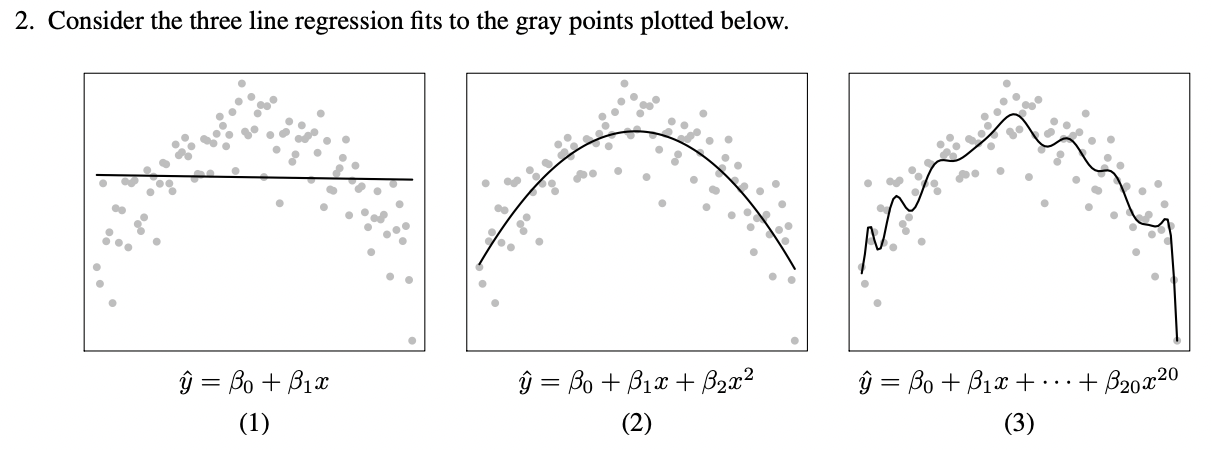



- (a) The estimate in (2) has a higher variance than the estimate in (1).
  - **True**, as the number of nearest neighbors decreases ((2) compare to (1)), the variance of the classifier will increase due to bias-variance trade-off. <br>
- (b) The estimate in (2) has a higher bias than the estimate in (3).
  - **True**,  (3) is a more complex model than (2), hence it will have a lower bias than (2). <br>
- (c) The estimate in (3) has the smallest training error.
  - **True**, (3) is the most complex model (lowest k), hence it will have the smallest training error. <br>
- (d) The estimate in (1) has the smallest test error.
  - **False**, (1) has the highest k-value, hence, it appears to be at the edge of our U-shaped curve, indicating in a higher than the lowest training error (often referred to as overfitting). <br>

### Q1.3
#### Misclassification rate of a classifier evaluated on a validation set will never be smaller than the one evaluated on the training set that is used to build the classifier.
- **False**. Generally, as the model created using the training dataset, and the validation/test set is an unknown dataset for the model, it has higher misclassification rate. But there still remains a possibility that the validation set (by sheer luck or coincidence!) performs equivalent or better than the training set. The word "never" used in the statement presents an impossibility clause.  <br>


### Q1.4
#### k-fold cross-validation provides an unbiased estimate of the predictive error of the models
- **False** It is very difficult or almost impossible to obtain unbiased estimates of predictive errors since we are never using the complete dataset for training, i.e., we always miss some data (kept for validation/test). Furthermore, lower number of folds (k) means higher bias. <br>

## Q2 Run a simulation study to explore the bias-variance trade-off in more depth
#### 1. You will start by exploring a scenario where the true relationship between x and y is linear. You will generate data from the linear model $ y = f(x) + \epsilon $ <br> where $ f(x) = 1.8x + 2 $

In [2]:
def gen_data_yaz(N):
    np.random.seed(410)
    x,y = [],[]
    for i in range(N):
        a = random.uniform(-1,1)
        epsilon = np.random.normal(0,0.1)
        yy = 1.8*a + 2 + epsilon
        
        x.append([a])
        y.append([yy])
        
    return np.array(x), np.array(y)

In [3]:
x,y=gen_data_yaz(100)

In [4]:
x_t,y_t = gen_data_yaz(10000)

#### 2. Create a scatter plot of $y$ vs $x$. In the same figure, draw the true relationship in black solid line.

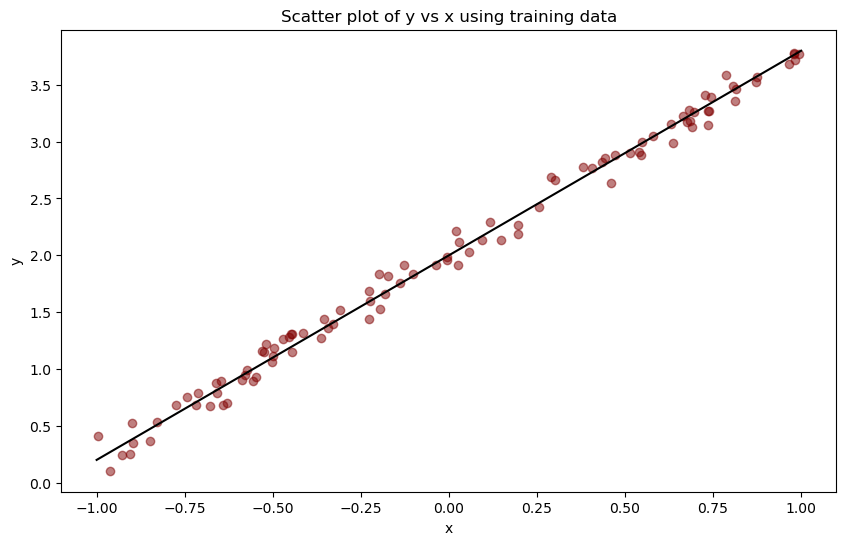

In [5]:
#plot y_train vs x_train
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x,y, color='maroon', alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.plot([-1,1], [1.8*-1+2, 1.8*1+2], color='black')
ax.set_title('Scatter plot of y vs x using training data')
plt.show()

#### 3. Using ordinary linear regression, find a relationship between y and x of the form <br> $y = b_0 + b_1 × x + e$ <br> using the training data you simulated. On the same plot from the last question, draw a blue dashed line that is the least squares fit to the data.

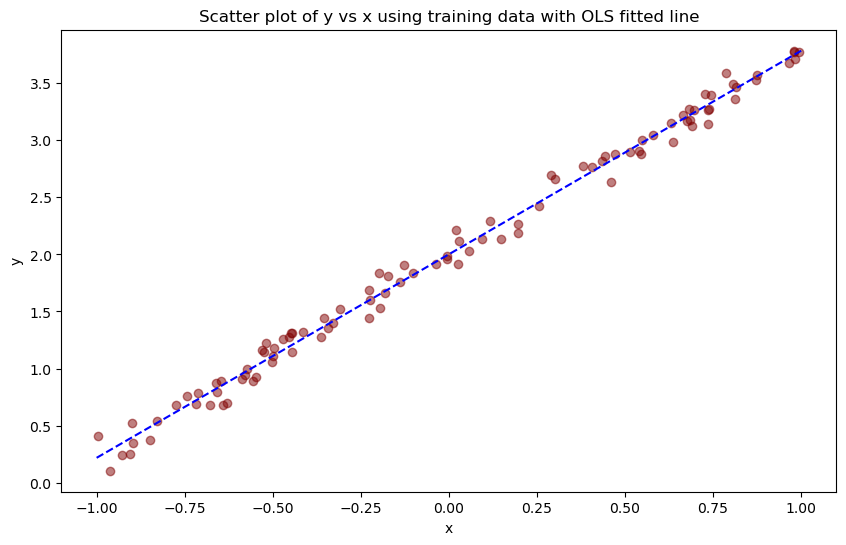

In [6]:
#Use ols to fit a linear regression model between y_train and x_train
res = ols('y ~ x', data=pd.DataFrame({'y':y[:,0], 'x':x[:,0]})).fit()
#on the same plot as above, plot the fitted line blue dashed line
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x,y, color='maroon', alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
#ax.plot([-1,1], [1.8*-1+2, 1.8*1+2], color='black', alpha=0.2)
ax.plot([-1,1], [res.params[0]+res.params[1]*-1, res.params[0]+res.params[1]*1], color='blue', linestyle='dashed')
ax.set_title('Scatter plot of y vs x using training data with OLS fitted line')
plt.show()

#### 4. Now, use k-NN to find the relationship between y and x. You should experiment with k = 2, 3, · · · , 15 to see how model complexity affects prediction accuracy. On one plot, redraw the scatter plot and the true relationship, but this time overlay it with predicted fit using k-NN with k = 2. On a juxtaposed graph, do the same for k = 12

In [7]:
def knn_performance(k=17, datagenerator=gen_data_yaz):
    x,y=datagenerator(100)
    x_t,y_t = datagenerator(10000)
    mse = pd.DataFrame(columns=['k','mse','complexity'])
    score = pd.DataFrame(columns=['k','test_score','train_score'])
    for i in range(1,k):
        knn = KNeighborsRegressor(n_neighbors=i)
        knn.fit(x,y)
        y_pred = knn.predict(x)
        test_score = knn.score(x_t,y_t)
        train_score = knn.score(x,y)
        y_pred_t = knn.predict(x_t)
        mse = pd.concat([mse, pd.DataFrame({'k':[i], 'mse':[mean_squared_error(y_t,y_pred_t)], 'complexity':[np.log(1/i)]})])
        score = pd.concat([score, pd.DataFrame({'k':[i], 'test_score':[test_score], 'train_score':[train_score]})])
        
        if i==2 or i==12:
            merged = pd.concat([pd.DataFrame(x), pd.DataFrame(y_pred)], axis=1)
            merged.columns = ['x', 'y_pred']
            
            #sort the merged dataframe by x
            merged = merged.sort_values(by=['x'])
            fig, ax = plt.subplots(figsize=(10, 6))
            ax.plot(merged['x'], merged['y_pred'], color='blue')
            #ax.plot([-1,1], [1.8*-1+2, 1.8*1+2], color='black', alpha=0.4)
            ax.scatter(x,y, color='maroon', alpha=0.5)
            ax.legend(['knn', 'true', 'data'])
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_title('Scatter plot of y vs x using training data with KNN fitted line for k={}'.format(i))
            plt.show()
        
    mse.set_index('k', inplace=True)
    score = score.set_index('k')
    return mse, score

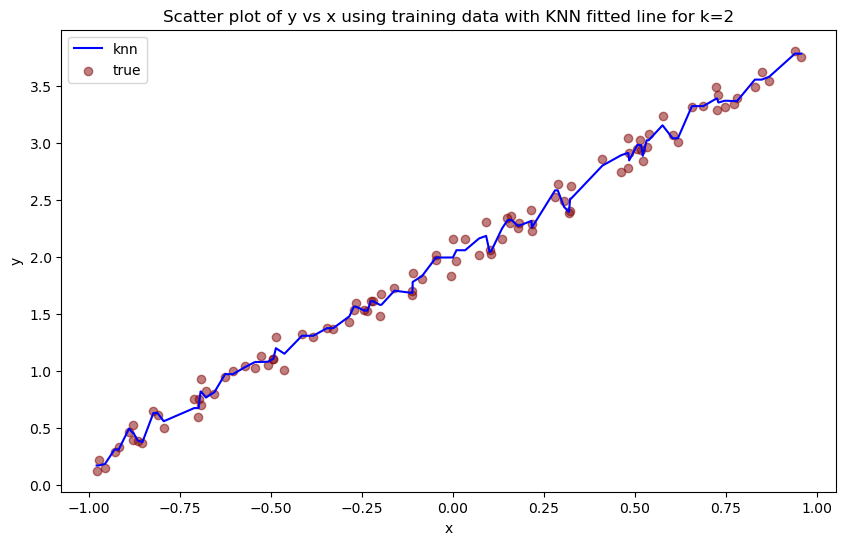

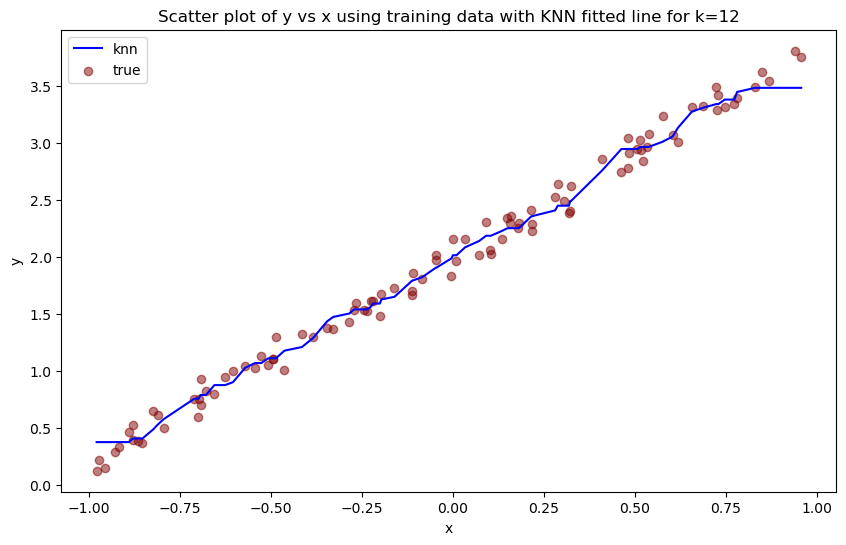

/usr/local/anaconda3/lib/python3.9/site-packages/pandas/core/indexes/base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)


In [8]:
mse, score = knn_performance(15)

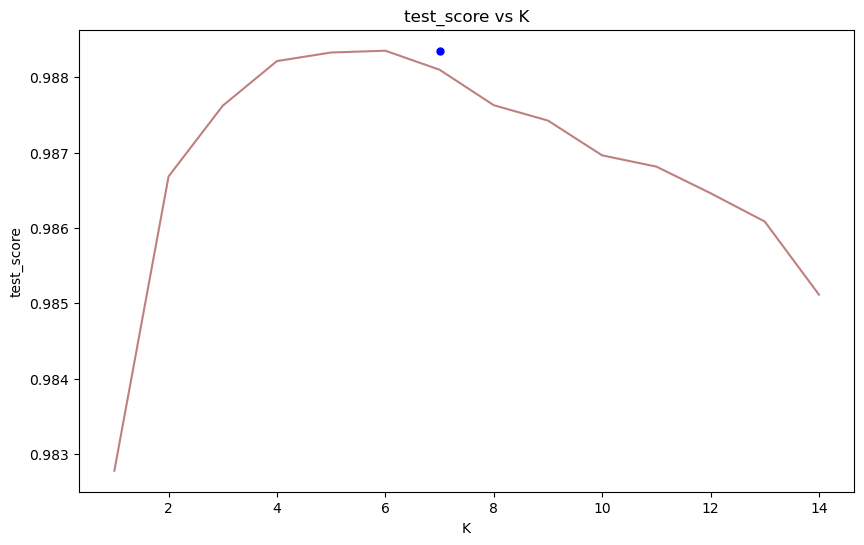

In [9]:
#plot a smooth curve for KNN Y prediction
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(score.index, score['test_score'], color='maroon', alpha=0.5)
ax.set_xlabel('K')
ax.set_ylabel('test_score')
#highlight the best K
ax.plot(score.index[score['test_score'].idxmax()], score['test_score'].max(), marker='o', markersize=5, color="blue")
ax.set_title('test_score vs K')
plt.show()

#### We note that as k increases the test_score increases to reach a maximum point and then starts diminishing. The two edges of the above graph represent the two extremes of the bias-variance trade-off. At the right edge, the model is too simple and has high bias. At the left edge, the model is too complex and has high variance. The optimal value of k is the one that minimizes the test error. <br>

#### 5. Plot the test set mean squared error using k-NN against log(1/k) for k = 2, 3, · · · , 15. On the same graph, draw a horizontal dashed line that represents the test set mean squared error using linear regression. Which model performs the best? Comment on the relative performance of linear regression and k-NN with different values of k.

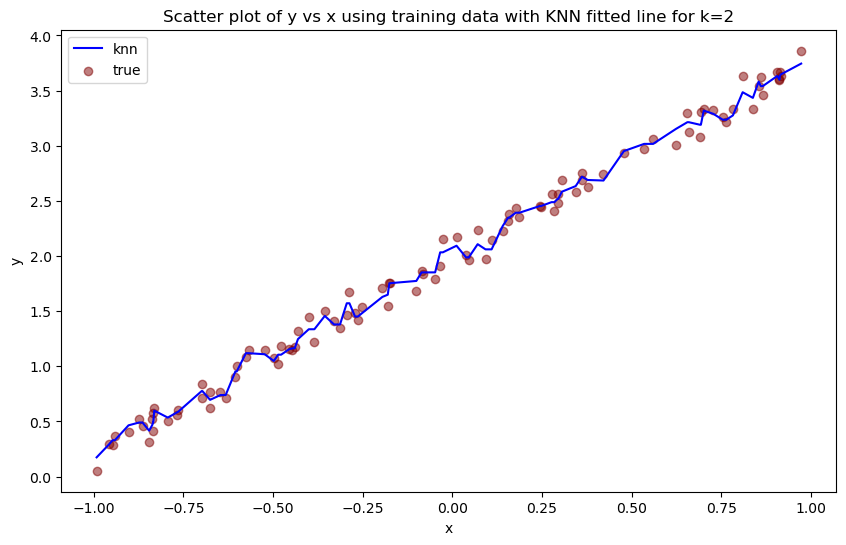

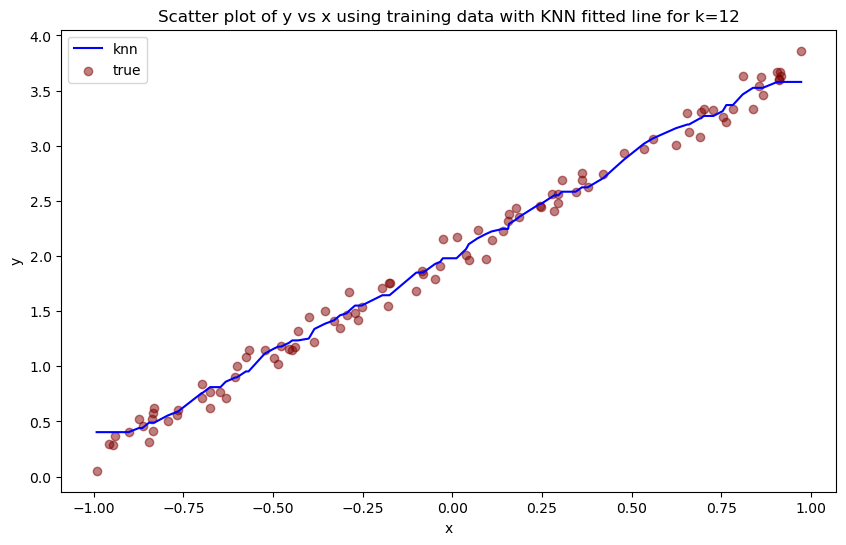

/usr/local/anaconda3/lib/python3.9/site-packages/pandas/core/indexes/base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)


In [10]:
mse, score = knn_performance(30)

### PLotting OLS model with the test set

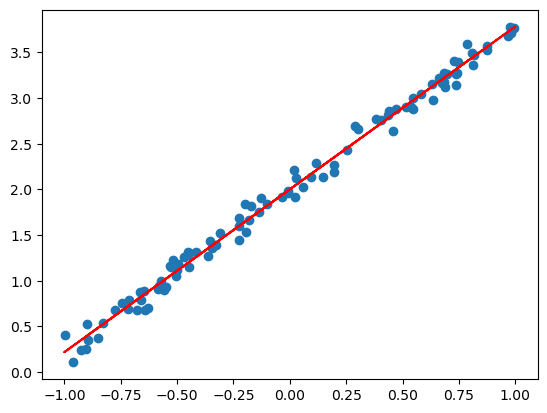

In [11]:
#add constant to x
x_new = sm.add_constant(x)
model = sm.OLS(y, x_new).fit()
x_t_new = sm.add_constant(x_t)
mean_squared_error(y_t, model.predict(x_t_new))
plt.scatter(x,y)
plt.plot(x_t, model.predict(x_t_new), color='red')

### Comparing the MSE of OLS and kNN models

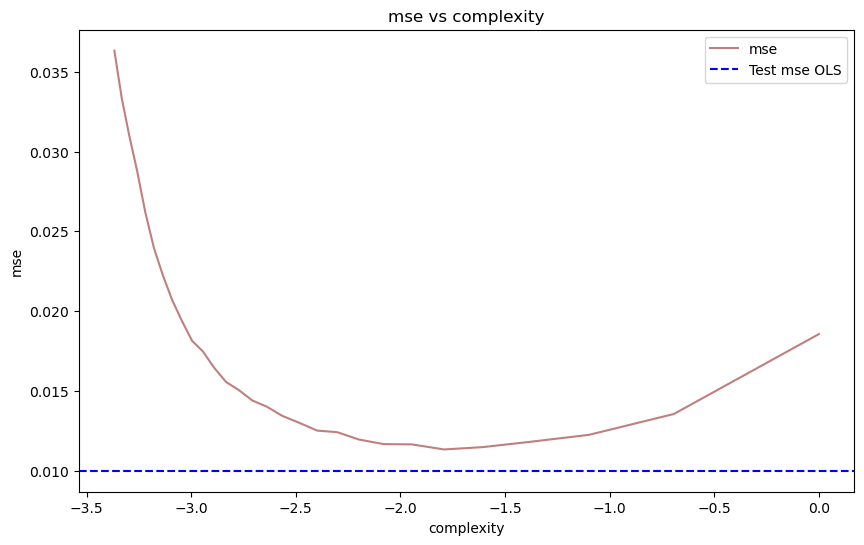

In [12]:
#plot mse vs complexity
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(mse['complexity'], mse['mse'], color='maroon', alpha=0.5)
ax.set_xlabel('complexity')
ax.set_ylabel('mse')
#On the same graph, draw a horizontal dashed line that represents the test set mean squared error using linear regression using x_t and y_t

ax.axhline(y=mean_squared_error(y_t, model.predict(x_t_new)), color='blue', linestyle='dashed')
ax.set_title('mse vs complexity')
#create a legend
ax.legend(['mse', 'Test mse OLS'])
plt.show()



#### The Linear Regression performs extremely well which is understandable given that we are looking at a strictly linear data generating function with very little normalised noise (epsilon)

### 6. Redo 1-5, but consider a different data generating process where the true relationship between x and y is near, but not perfectly linear.

In [13]:
def gen_data_aman(N):
    np.random.seed(410)
    x,y = [],[]
    for i in range(N):
        a = random.uniform(-1,1)
        epsilon = np.random.normal(0,0.1)
        #yy =tanh(1.1×a)+2+epsilon
        yy = np.tanh(1.1*a)+2+epsilon
        
        x.append([a])
        y.append([yy])
        
    return np.array(x), np.array(y)

In [14]:
x,y=gen_data_aman(100)
x_t,y_t = gen_data_aman(10000)

#### Create a scatter plot of $y$ vs $x$. In the same figure, draw the true relationship in black solid line.

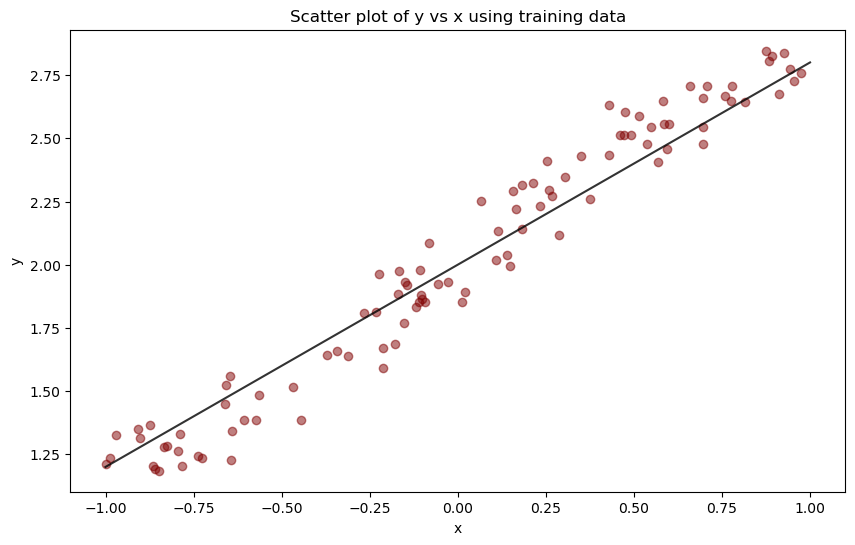

In [15]:
#plot y_train vs x_train
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x,y, color='maroon', alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.plot([-1,1], [np.tanh(1.1*-1)+2, np.tanh(1.1*1)+2], color='black', alpha=0.8)
ax.set_title('Scatter plot of y vs x using training data')
plt.show()

### Using ordinary linear regression, find a relationship between y and x of the form <br> $y = b_0 + b_1 × x + e$ <br> using the training data you simulated. On the same plot from the last question, draw a blue dashed line that is the least squares fit to the data.

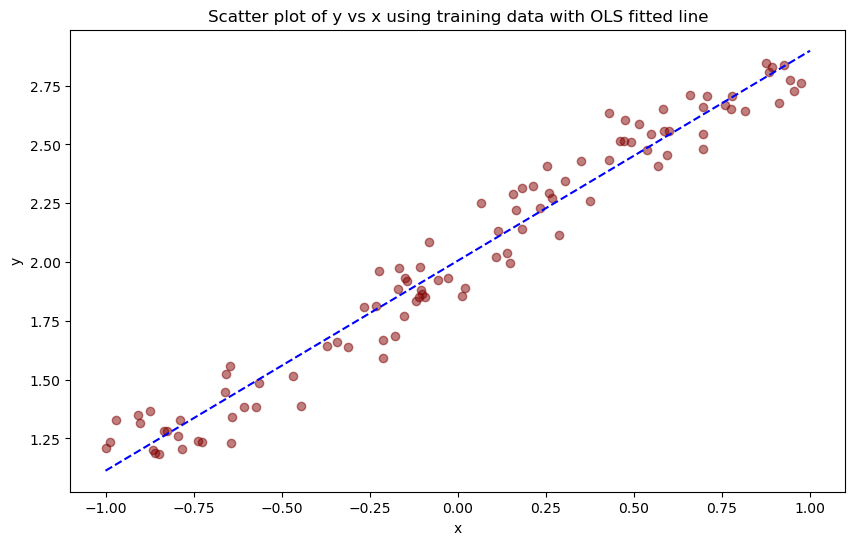

In [16]:
#Use ols to fit a linear regression model between y_train and x_train
res = ols('y ~ x', data=pd.DataFrame({'y':y[:,0], 'x':x[:,0]})).fit()
#on the same plot as above, plot the fitted line blue dashed line
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x,y, color='maroon', alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
#ax.plot([-1,1], [1.8*-1+2, 1.8*1+2], color='black', alpha=0.2)
ax.plot([-1,1], [res.params[0]+res.params[1]*-1, res.params[0]+res.params[1]*1], color='blue', linestyle='dashed')
ax.set_title('Scatter plot of y vs x using training data with OLS fitted line')
plt.show()

#### Now, use k-NN to find the relationship between y and x. You should experiment with k = 2, 3, · · · , 15 to see how model complexity affects prediction accuracy. On one plot, redraw the scatter plot and the true relationship, but this time overlay it with predicted fit using k-NN with k = 2. On a juxtaposed graph, do the same for k = 12

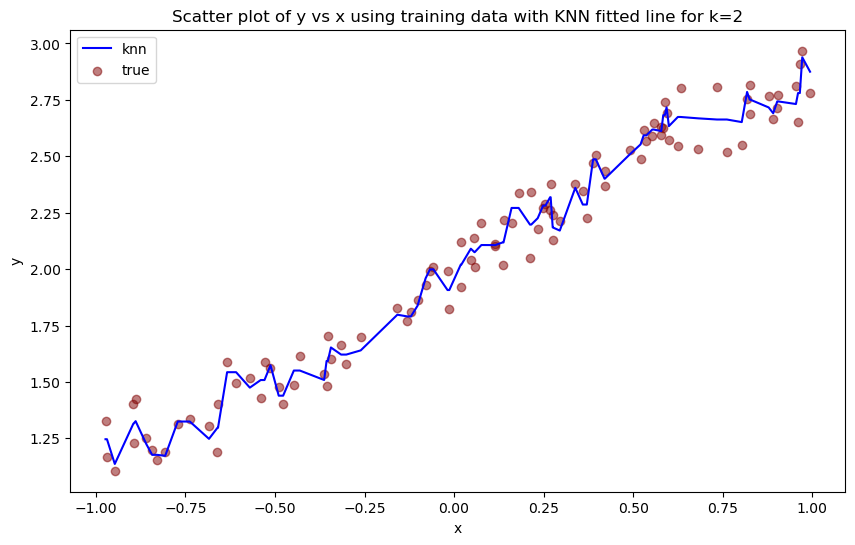

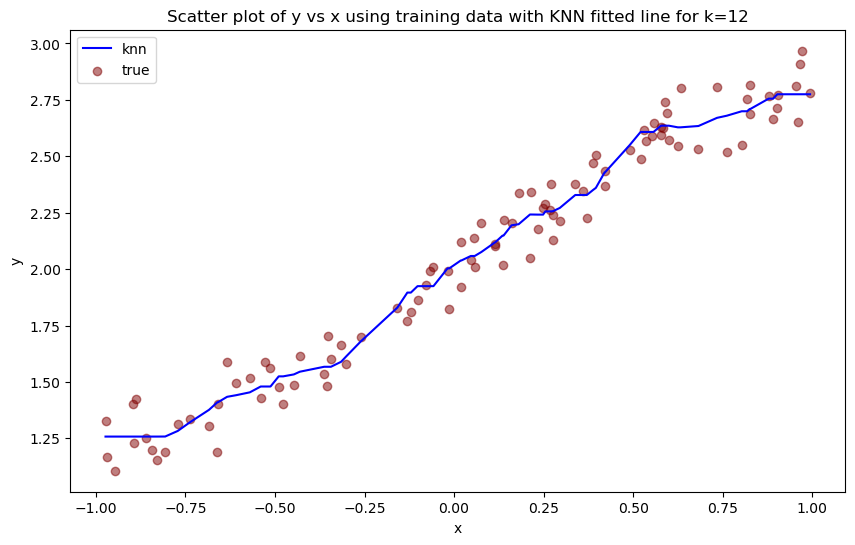

/usr/local/anaconda3/lib/python3.9/site-packages/pandas/core/indexes/base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)


In [17]:
mse, score = knn_performance(30,gen_data_aman)

### PLot the test score vs K

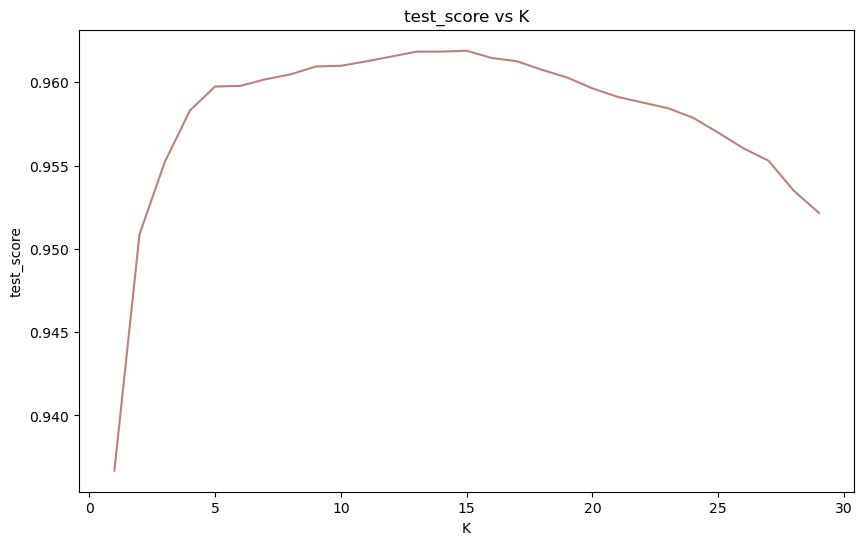

In [18]:
#plot a smooth curve for KNN Y prediction
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(score.index, score['test_score'], color='maroon', alpha=0.5)
ax.set_xlabel('K')
ax.set_ylabel('test_score')
#highlight the best K
#ax.plot(score.index[score['test_score'].idxmax()], score['test_score'].max(), marker='o', markersize=5, color="blue")
ax.set_title('test_score vs K')
plt.show()

### PLotting OLS model with the test set

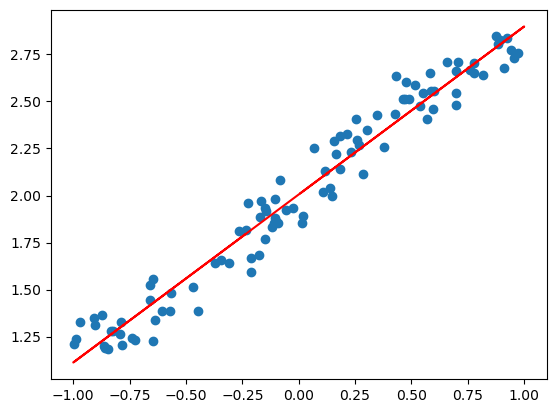

In [19]:
#add constant to x
x_new = sm.add_constant(x)
model = sm.OLS(y, x_new).fit()
x_t_new = sm.add_constant(x_t)
mean_squared_error(y_t, model.predict(x_t_new))
plt.scatter(x,y)
plt.plot(x_t, model.predict(x_t_new), color='red')

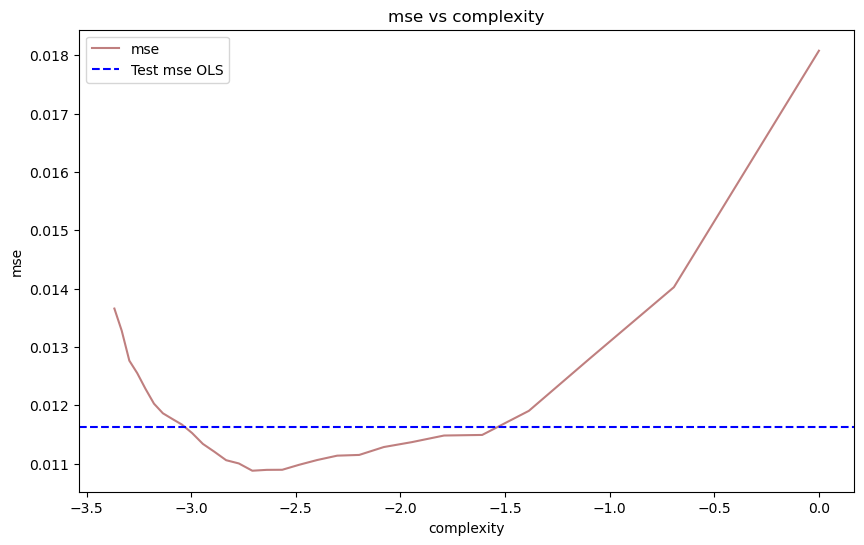

In [20]:
#plot mse vs complexity
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(mse['complexity'], mse['mse'], color='maroon', alpha=0.5)
ax.set_xlabel('complexity')
ax.set_ylabel('mse')
#On the same graph, draw a horizontal dashed line that represents the test set mean squared error using linear regression using x_t and y_t

ax.axhline(y=mean_squared_error(y_t, model.predict(x_t_new)), color='blue', linestyle='dashed')
ax.set_title('mse vs complexity')
#create a legend
ax.legend(['mse', 'Test mse OLS'])
plt.show()



#### The Linear Regression model still performs good, but we see a range of K's where the KNN model performs better than the OLS model. This is because the data generating function is not strictly linear, and hence the OLS model is not able to capture the true relationship between X and Y.

### 7. Consider yet another data generating process where the true relationship is strongly non-linear. 

In [21]:
def gen_data_jing(N):
    np.random.seed(410)
    x,y = [],[]
    for i in range(N):
        a = random.uniform(-1,1)
        epsilon = np.random.normal(0,0.1)
        #yy =sin(2 * a)+2+epsilon
        yy = np.sin(2 * a)+2+epsilon
        
        x.append([a])
        y.append([yy])
        
    return np.array(x), np.array(y)

In [22]:
x,y=gen_data_jing(100)
x_t,y_t = gen_data_jing(10000)

#### Create a scatter plot of $y$ vs $x$. In the same figure, draw the true relationship in black solid line.

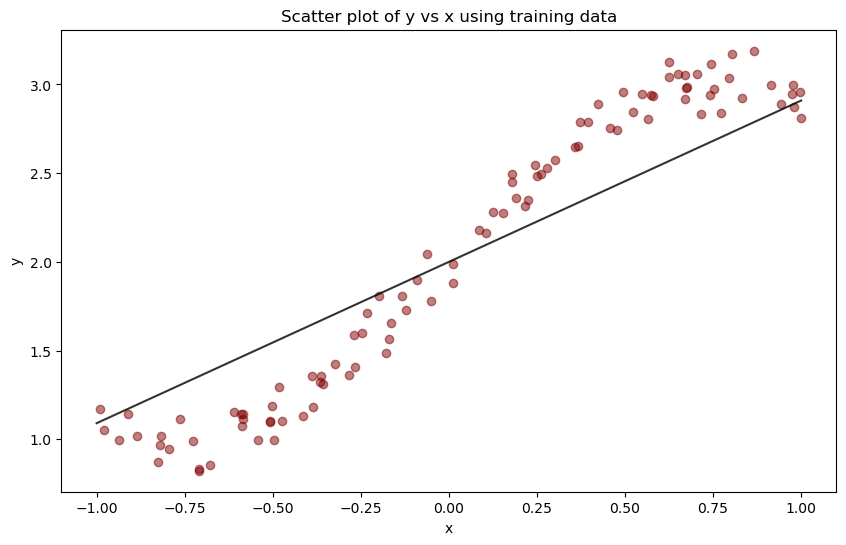

In [23]:
#plot y_train vs x_train
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x,y, color='maroon', alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.plot([-1,1], [np.sin(2*-1)+2, np.sin(2*1)+2], color='black', alpha=0.8)
ax.set_title('Scatter plot of y vs x using training data')
plt.show()

### Using ordinary linear regression, find a relationship between y and x of the form <br> $y = b_0 + b_1 × x + e$ <br> using the training data you simulated. On the same plot from the last question, draw a blue dashed line that is the least squares fit to the data.

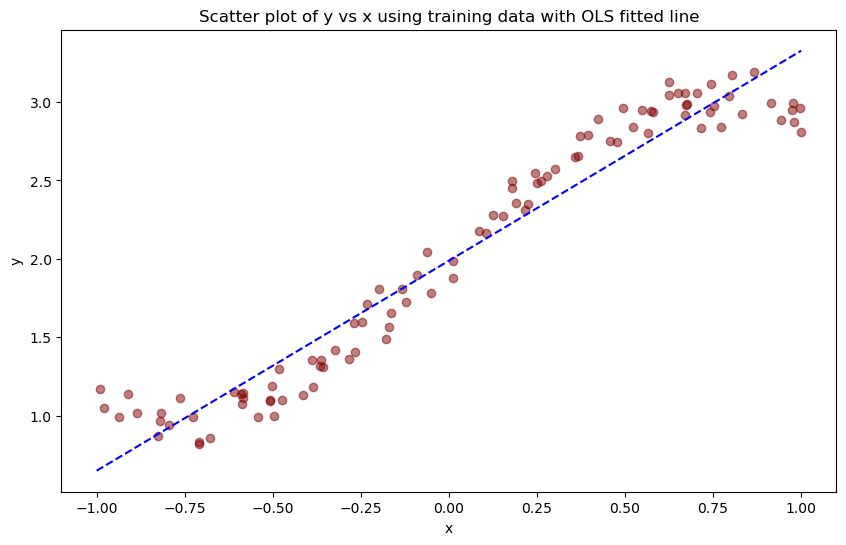

In [24]:
#Use ols to fit a linear regression model between y_train and x_train
res = ols('y ~ x', data=pd.DataFrame({'y':y[:,0], 'x':x[:,0]})).fit()
#on the same plot as above, plot the fitted line blue dashed line
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x,y, color='maroon', alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
#ax.plot([-1,1], [1.8*-1+2, 1.8*1+2], color='black', alpha=0.2)
ax.plot([-1,1], [res.params[0]+res.params[1]*-1, res.params[0]+res.params[1]*1], color='blue', linestyle='dashed')
ax.set_title('Scatter plot of y vs x using training data with OLS fitted line')
plt.show()

#### Now, use k-NN to find the relationship between y and x. You should experiment with k = 2, 3, · · · , 15 to see how model complexity affects prediction accuracy. On one plot, redraw the scatter plot and the true relationship, but this time overlay it with predicted fit using k-NN with k = 2. On a juxtaposed graph, do the same for k = 12

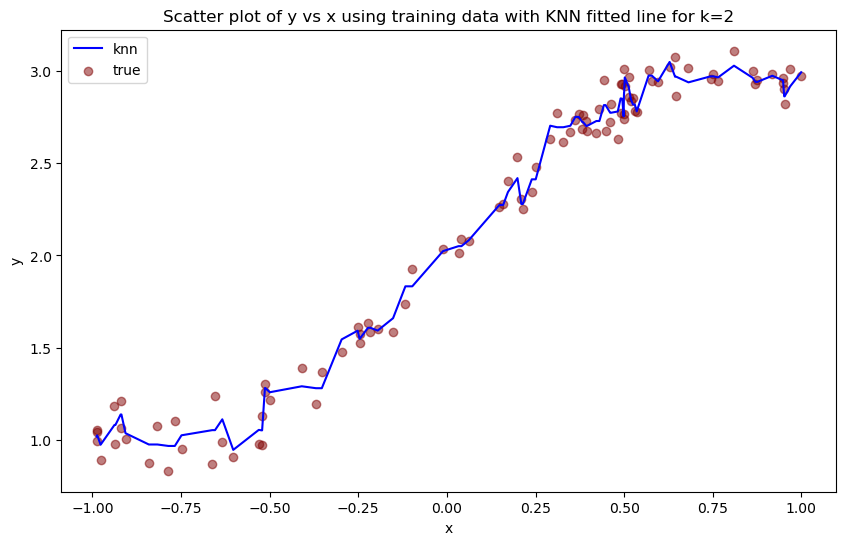

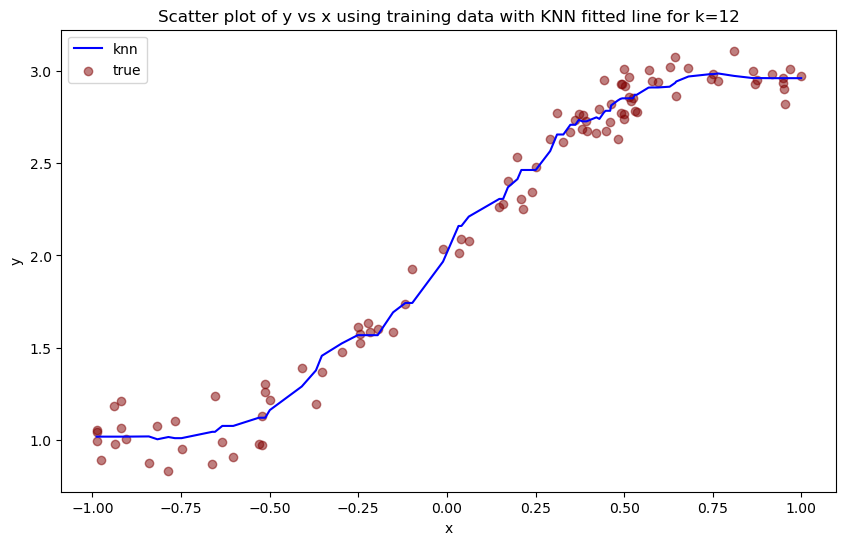

/usr/local/anaconda3/lib/python3.9/site-packages/pandas/core/indexes/base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)


In [25]:
mse, score = knn_performance(30,gen_data_jing)

### PLot the test score vs K

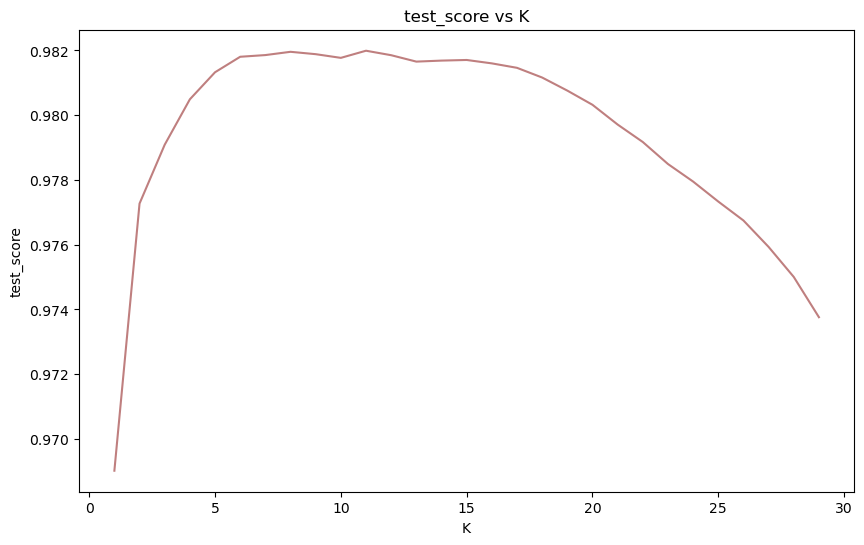

In [26]:
#plot a smooth curve for KNN Y prediction
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(score.index, score['test_score'], color='maroon', alpha=0.5)
ax.set_xlabel('K')
ax.set_ylabel('test_score')
#highlight the best K
#ax.plot(score.index[score['test_score'].idxmax()], score['test_score'].max(), marker='o', markersize=5, color="blue")
ax.set_title('test_score vs K')
plt.show()

### PLotting OLS model with the test set

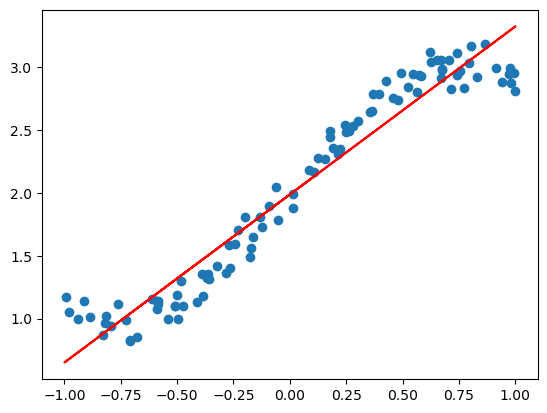

In [27]:
#add constant to x
x_new = sm.add_constant(x)
model = sm.OLS(y, x_new).fit()
x_t_new = sm.add_constant(x_t)
mean_squared_error(y_t, model.predict(x_t_new))
plt.scatter(x,y)
plt.plot(x_t, model.predict(x_t_new), color='red')

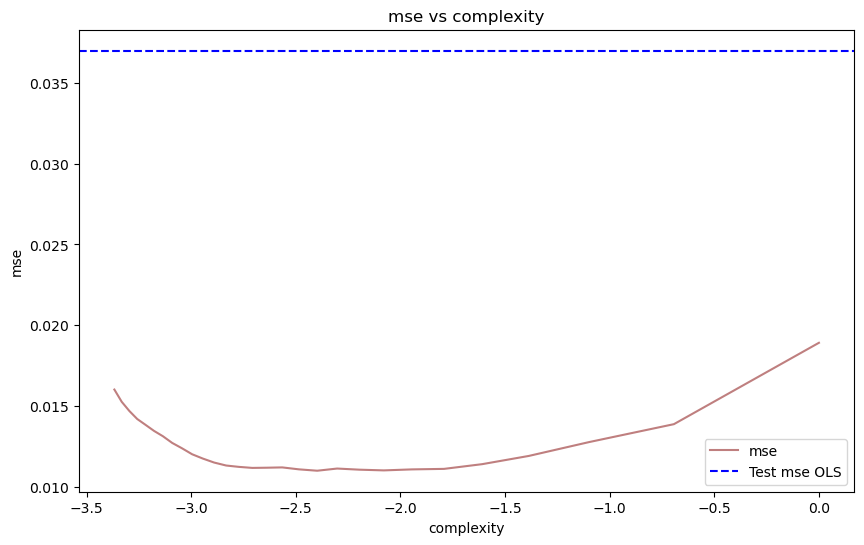

In [28]:
#plot mse vs complexity
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(mse['complexity'], mse['mse'], color='maroon', alpha=0.5)
ax.set_xlabel('complexity')
ax.set_ylabel('mse')
#On the same graph, draw a horizontal dashed line that represents the test set mean squared error using linear regression using x_t and y_t

ax.axhline(y=mean_squared_error(y_t, model.predict(x_t_new)), color='blue', linestyle='dashed')
ax.set_title('mse vs complexity')
#create a legend
ax.legend(['mse', 'Test mse OLS'])
plt.show()



#### The Linear Regression model performs extremely poorly, and the KNN model performs better than the OLS model for all values of K. This is because the data generating function is not linear, and hence the OLS model is not able to capture the true relationship between X and Y.

#### 8. You might suspect, from your previous results, that in real world when none of the relationship could be linear, it would always pay off using k-NN over linear regression. Examine this hypothesis in the situation with more than 1 variable. 

In [29]:
def gen_data_christ(N, p=1):
    np.random.seed(410)
    x,y = [],[]
    for i in range(N):
        noise=0
        a = random.uniform(-1,1)
        epsilon = np.random.normal(0,0.1)
        #yy =sin(2 * a)+2+epsilon
        for j in range(p):
            noise+=random.uniform(-1,1)
        yy = np.sin(2 * a)+2+epsilon + noise
        
        x.append([a])
        y.append([yy])
        
    return np.array(x), np.array(y)

In [30]:
x,y=gen_data_christ(100,1)
x_t,y_t = gen_data_christ(10000,1)

In [31]:
def knn_performance(k=17, datagenerator=gen_data_yaz,p=1, plot=False):
    x,y=datagenerator(100,p)
    x_t,y_t = datagenerator(10000,p)
    mse = pd.DataFrame(columns=['k','mse','complexity'])
    score = pd.DataFrame(columns=['k','test_score','train_score'])
    for i in range(1,k):
        knn = KNeighborsRegressor(n_neighbors=i)
        knn.fit(x,y)
        y_pred = knn.predict(x)
        test_score = knn.score(x_t,y_t)
        train_score = knn.score(x,y)
        y_pred_t = knn.predict(x_t)
        mse = pd.concat([mse, pd.DataFrame({'k':[i], 'mse':[mean_squared_error(y_t,y_pred_t)], 'complexity':[np.log(1/i)]})])
        score = pd.concat([score, pd.DataFrame({'k':[i], 'test_score':[test_score], 'train_score':[train_score]})])
        
        if (i==2 or i==12) and plot:
            merged = pd.concat([pd.DataFrame(x), pd.DataFrame(y_pred)], axis=1)
            merged.columns = ['x', 'y_pred']
            
            #sort the merged dataframe by x
            merged = merged.sort_values(by=['x'])
            fig, ax = plt.subplots(figsize=(10, 6))
            ax.plot(merged['x'], merged['y_pred'], color='blue')
            #ax.plot([-1,1], [1.8*-1+2, 1.8*1+2], color='black', alpha=0.4)
            ax.scatter(x,y, color='maroon', alpha=0.5)
            ax.legend(['knn', 'true', 'data'])
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_title('Scatter plot of y vs x using training data with KNN fitted line for k={}'.format(i))
            plt.show()
        
    mse.set_index('k', inplace=True)
    score = score.set_index('k')
    return mse, score

## P=1

/usr/local/anaconda3/lib/python3.9/site-packages/pandas/core/indexes/base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)


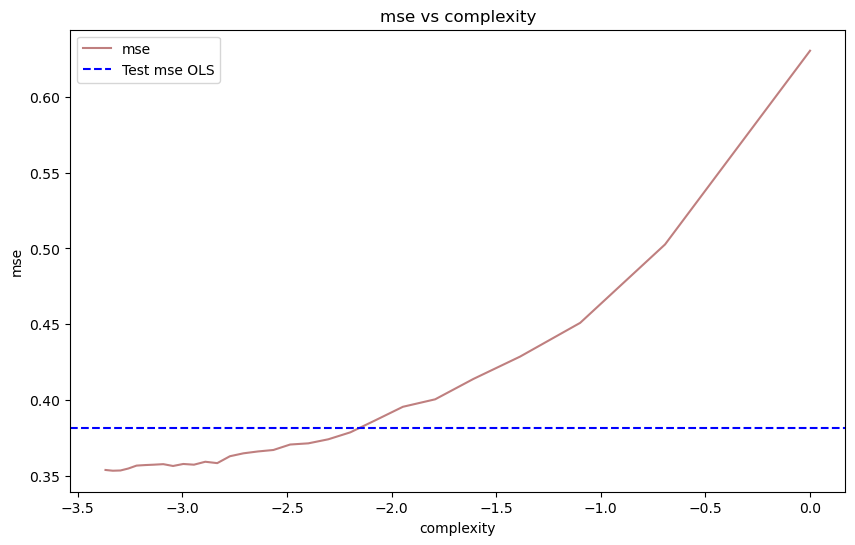

In [32]:
mse, score = knn_performance(30,gen_data_christ,1,False)
#add constant to x
x_new = sm.add_constant(x)
model = sm.OLS(y, x_new).fit()
x_t_new = sm.add_constant(x_t)
mse_ols = mean_squared_error(y_t, model.predict(x_t_new))
#plot mse vs complexity
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(mse['complexity'], mse['mse'], color='maroon', alpha=0.5)
ax.set_xlabel('complexity')
ax.set_ylabel('mse')
#On the same graph, draw a horizontal dashed line that represents the test set mean squared error using linear regression using x_t and y_t

ax.axhline(y=mean_squared_error(y_t, model.predict(x_t_new)), color='blue', linestyle='dashed')
ax.set_title('mse vs complexity')
#create a legend
ax.legend(['mse', 'Test mse OLS'])
plt.show()



## P=2

/usr/local/anaconda3/lib/python3.9/site-packages/pandas/core/indexes/base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)


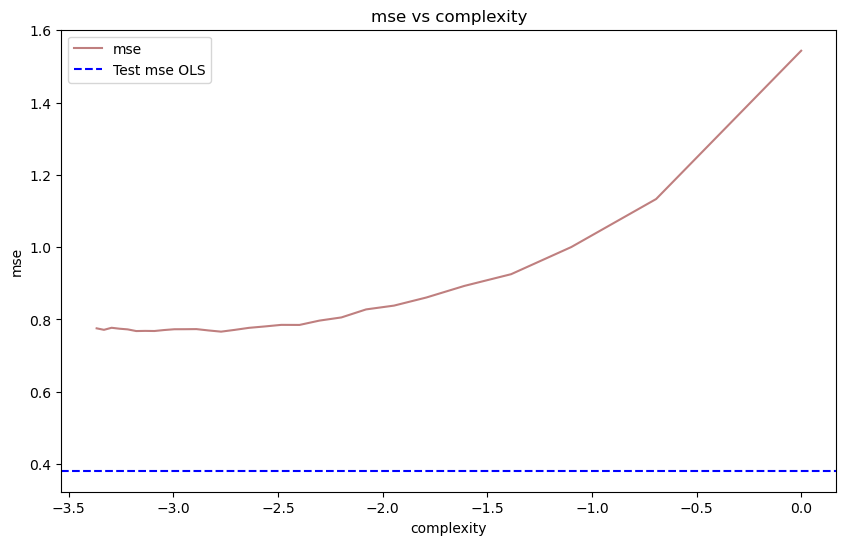

In [33]:
mse, score = knn_performance(30,gen_data_christ,2,False)
#add constant to x
x_new = sm.add_constant(x)
model = sm.OLS(y, x_new).fit()
x_t_new = sm.add_constant(x_t)
mse_ols = mean_squared_error(y_t, model.predict(x_t_new))
#plot mse vs complexity
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(mse['complexity'], mse['mse'], color='maroon', alpha=0.5)
ax.set_xlabel('complexity')
ax.set_ylabel('mse')
#On the same graph, draw a horizontal dashed line that represents the test set mean squared error using linear regression using x_t and y_t

ax.axhline(y=mean_squared_error(y_t, model.predict(x_t_new)), color='blue', linestyle='dashed')
ax.set_title('mse vs complexity')
#create a legend
ax.legend(['mse', 'Test mse OLS'])
plt.show()



## P=5

/usr/local/anaconda3/lib/python3.9/site-packages/pandas/core/indexes/base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)


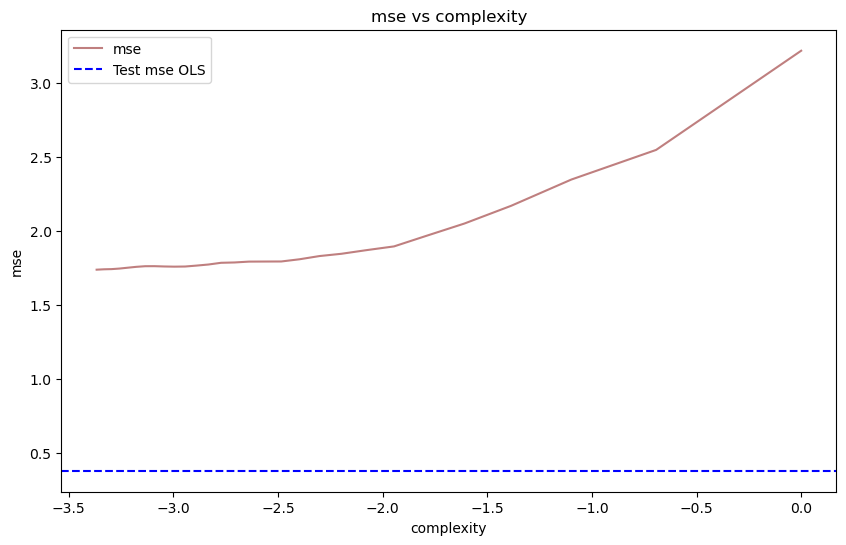

In [34]:
mse, score = knn_performance(30,gen_data_christ,5,False)
#add constant to x
x_new = sm.add_constant(x)
model = sm.OLS(y, x_new).fit()
x_t_new = sm.add_constant(x_t)
mse_ols = mean_squared_error(y_t, model.predict(x_t_new))
#plot mse vs complexity
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(mse['complexity'], mse['mse'], color='maroon', alpha=0.5)
ax.set_xlabel('complexity')
ax.set_ylabel('mse')
#On the same graph, draw a horizontal dashed line that represents the test set mean squared error using linear regression using x_t and y_t

ax.axhline(y=mean_squared_error(y_t, model.predict(x_t_new)), color='blue', linestyle='dashed')
ax.set_title('mse vs complexity')
#create a legend
ax.legend(['mse', 'Test mse OLS'])
plt.show()



## P=10

/usr/local/anaconda3/lib/python3.9/site-packages/pandas/core/indexes/base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)


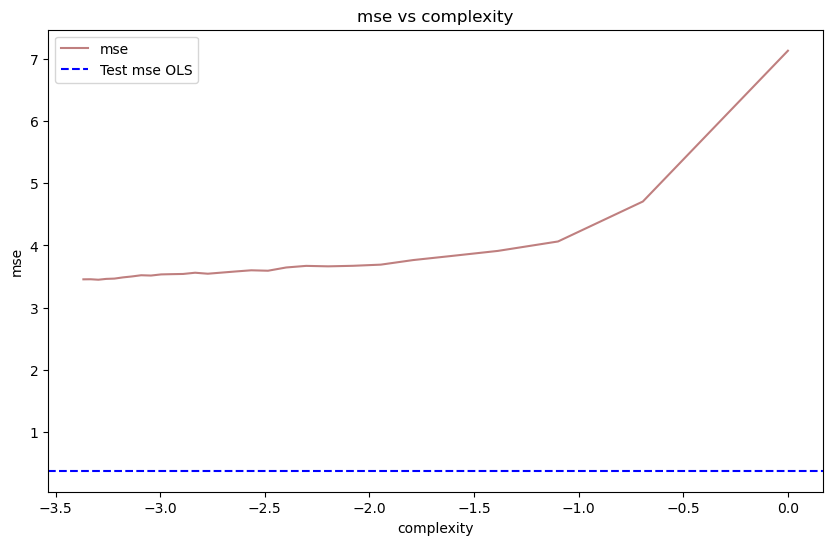

In [35]:
mse, score = knn_performance(30,gen_data_christ,10,False)
#add constant to x
x_new = sm.add_constant(x)
model = sm.OLS(y, x_new).fit()
x_t_new = sm.add_constant(x_t)
mse_ols = mean_squared_error(y_t, model.predict(x_t_new))
#plot mse vs complexity
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(mse['complexity'], mse['mse'], color='maroon', alpha=0.5)
ax.set_xlabel('complexity')
ax.set_ylabel('mse')
#On the same graph, draw a horizontal dashed line that represents the test set mean squared error using linear regression using x_t and y_t

ax.axhline(y=mean_squared_error(y_t, model.predict(x_t_new)), color='blue', linestyle='dashed')
ax.set_title('mse vs complexity')
#create a legend
ax.legend(['mse', 'Test mse OLS'])
plt.show()



## P=20

/usr/local/anaconda3/lib/python3.9/site-packages/pandas/core/indexes/base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)


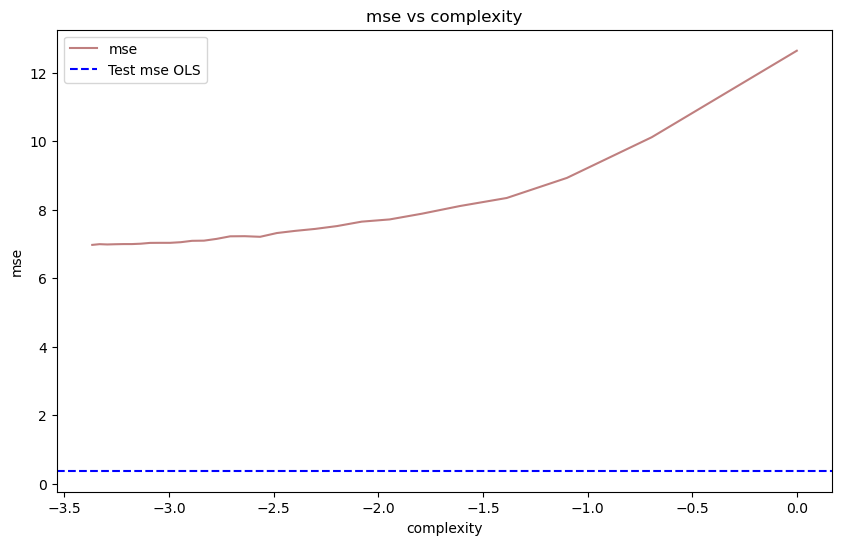

In [36]:
mse, score = knn_performance(30,gen_data_christ,20,False)
#add constant to x
x_new = sm.add_constant(x)
model = sm.OLS(y, x_new).fit()
x_t_new = sm.add_constant(x_t)
mse_ols = mean_squared_error(y_t, model.predict(x_t_new))
#plot mse vs complexity
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(mse['complexity'], mse['mse'], color='maroon', alpha=0.5)
ax.set_xlabel('complexity')
ax.set_ylabel('mse')
#On the same graph, draw a horizontal dashed line that represents the test set mean squared error using linear regression using x_t and y_t

ax.axhline(y=mean_squared_error(y_t, model.predict(x_t_new)), color='blue', linestyle='dashed')
ax.set_title('mse vs complexity')
#create a legend
ax.legend(['mse', 'Test mse OLS'])
plt.show()



#### We observe that random noise in the data affects the KNN model more than the OLS model. This is because the KNN model is more sensitive to noise in the data, and hence the KNN model performs worse than the OLS model when the data is noisy. As we increase the number of random variables, the OLS model performs better than the KNN model. This is because the OLS model is able to capture the true relationship between X and Y better than the KNN model when the data is noisy.

### 9. Suppose that instead of 100 training samples, you had 1,000 training samples. Would that change conclusions you made above? Think about how the range of values of k for which k-NN does better that linear regression would change. What does having a large training set allow you to do?

- **Yes**. The range of values of k for which k-NN does better that linear regression would change. Having a large training set allows us to use a larger value of k, and hence the KNN model would perform better than the OLS model for a larger range of values of k. <br>
- Furthermore, we would see and overall improvement across both models as we increase the number of training samples. This is because the OLS model would be able to capture the true relationship between X and Y better as we increase the number of training samples, and the KNN model would be less sensitive to noise in the data as we increase the number of training samples. <br>

## Q3 In this question, you will explore prices of used cars as a function of different input variables. Download the file UsedCars.csv from Canvas.

In [37]:
used_cars = pd.read_csv('UsedCars.csv')
used_cars.head()

,price,trim,isOneOwner,mileage,year,color,displacement,fuel,region,soundSystem,wheelType
0,2988,320,f,193296.0000,1995,Black,3.2000,Gasoline,SoA,unsp,Alloy
1,6595,320,f,129948.0000,1995,other,3.2000,Gasoline,Mid,Premium,Alloy
2,7993,320,f,140428.0000,1997,White,3.2000,Gasoline,Mid,Bose,Alloy
3,5995,420,f,113622.0000,1999,Silver,4.2000,Gasoline,Mid,unsp,Alloy
4,3000,420,f,167673.0000,1999,Silver,4.2000,Gasoline,SoA,unsp,Alloy


### 1. Take a look at the data-set and describe for what kind of business related problems you could use this data. That is, why would anyone care to collect this data?
- The data-set contains information about the price of used cars, and the different features of the used cars
- This data-set could be used to predict the price of a used car given the features of the used car.
- Or Vice-versa, we could predict the features of a used car given the price of the used car. <br>

####  2. Using ordinary linear regression, find a relationship between price and mileage of the form <br> $ price=b_0 +b_1 ×mileage+e $ <br> using the training data. Create a scatter plot of price vs mileage. Include the best linear regression fit onto the plot.

In [38]:
model = ols('price ~ mileage', data=used_cars).fit()
print(model.summary()) 

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                 3.438e+04
Date:                Fri, 20 Jan 2023   Prob (F-statistic):               0.00
Time:                        10:41:53   Log-Likelihood:            -2.1535e+05
No. Observations:               20063   AIC:                         4.307e+05
Df Residuals:                   20061   BIC:                         4.307e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.542e+04    154.429    358.866      0.0

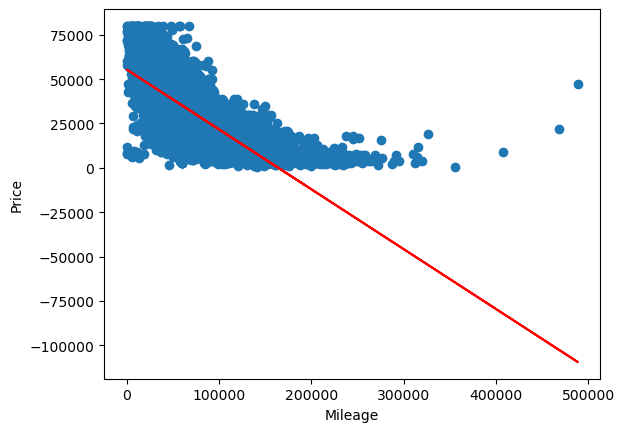

In [39]:
# Create a scatter plot of price vs mileage and plot the regression calculated above
plt.scatter(used_cars['mileage'], used_cars['price'])
plt.plot(used_cars['mileage'], model.predict(), color='red')
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.show()

### 3. You might notice that the linear fit does not capture the true relationship well. Use k-NN and regression trees to find the relationship between price and mileage. Use cross-validation to find the optimal tuning parameters for these two procedures: k for k-NN and the number of leaves for decision trees.

In [40]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(used_cars[['mileage']], used_cars['price'], test_size=0.2, random_state=42)

In [41]:
def knn_performance(k=17, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    x,y=X_train,y_train
    x_t,y_t = X_test,y_test
    mse = pd.DataFrame(columns=['k','mse','complexity'])
    score = pd.DataFrame(columns=['k','test_score','train_score'])
    for i in range(1,k):
        knn = KNeighborsRegressor(n_neighbors=i)
        knn.fit(x,y)
        y_pred = knn.predict(x)
        test_score = knn.score(x_t,y_t)
        train_score = knn.score(x,y)
        y_pred_t = knn.predict(x_t)
        mse = pd.concat([mse, pd.DataFrame({'k':[i], 'mse':[mean_squared_error(y_t,y_pred_t)], 'complexity':[np.log(1/i)]})])
        score = pd.concat([score, pd.DataFrame({'k':[i], 'test_score':[test_score], 'train_score':[train_score]})])
        
        if i==2 or i==12:
            merged = pd.concat([pd.DataFrame(x), pd.DataFrame(y_pred)], axis=1)
            merged.columns = ['x', 'y_pred']
            
            #sort the merged dataframe by x
            merged = merged.sort_values(by=['x'])
            fig, ax = plt.subplots(figsize=(10, 6))
            ax.scatter(merged['x'], merged['y_pred'], color='blue')
            #ax.plot([-1,1], [1.8*-1+2, 1.8*1+2], color='black', alpha=0.4)
            ax.scatter(x,y, color='maroon', alpha=0.5)
            ax.legend(['knn', 'true', 'data'])
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_title('Scatter plot of y vs x using training data with KNN fitted line for k={}'.format(i))
            plt.show()
        
    mse.set_index('k', inplace=True)
    score = score.set_index('k')
    return mse, score

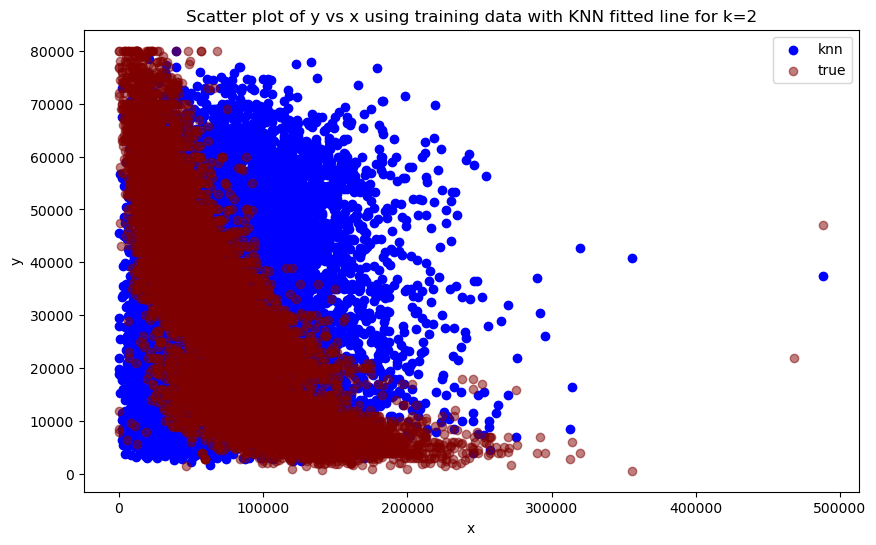

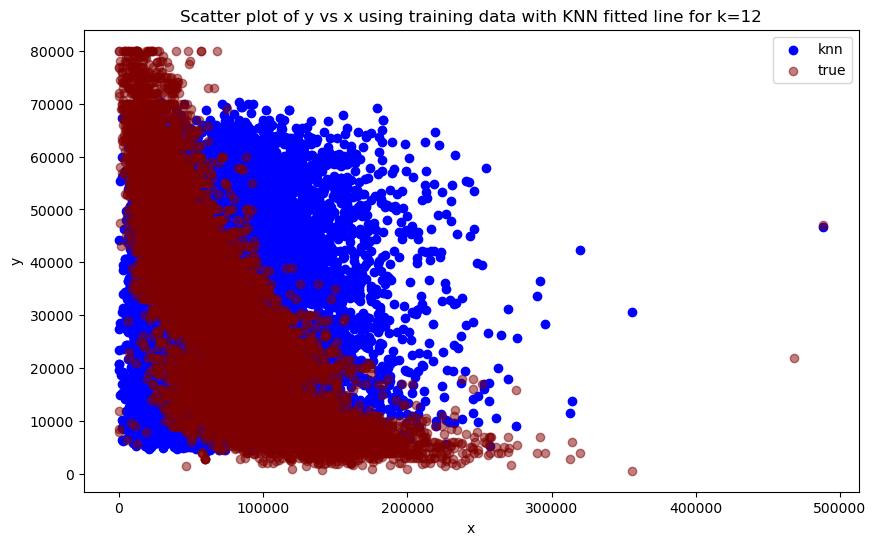

/usr/local/anaconda3/lib/python3.9/site-packages/pandas/core/indexes/base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)


In [42]:
mse, score = knn_performance(40)

In [43]:
score

,test_score,train_score
k,,
1,0.4702,0.9582
2,0.5960,0.8617
3,0.6451,0.8192
4,0.6681,0.7974
5,0.6801,0.7839
6,0.6862,0.7743
7,0.6938,0.7679
8,0.6975,0.7639
9,0.7023,0.7603


### Decision Tree Classification

In [44]:
k=17
clf = DecisionTreeClassifier(max_depth=k)
clf_model = clf.fit(X_train, y_train)
y_pred_dt = clf_model.predict(X_test)

Text(0.5, 1.0, 'Scatter plot of y vs x using testing data with Decision Tree fitted line for k=17')

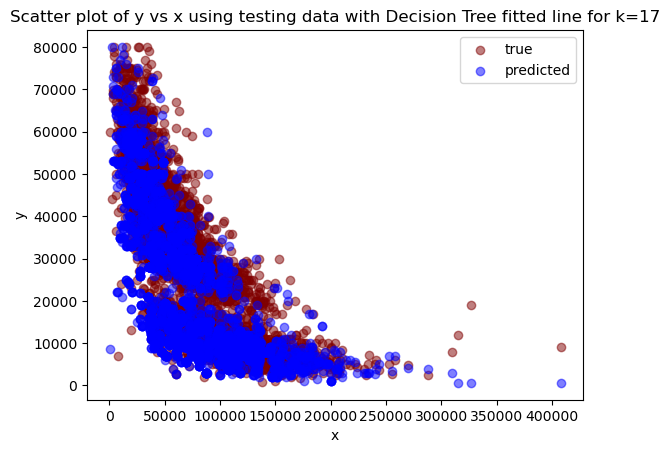

In [45]:
plt.scatter(X_test, y_test, color='maroon', alpha=0.5)
plt.scatter(X_test, y_pred_dt, color='blue', alpha=0.5)
plt.legend(['true', 'predicted'])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatter plot of y vs x using testing data with Decision Tree fitted line for k={}'.format(k))

In [46]:
lpo = LeavePOut(p=200)
scores = cross_val_score(clf, used_cars[['mileage']], used_cars['price'], cv = lpo)

KeyboardInterrupt: 

In [ ]:
print("Cross Validation Scores: ", scores)
print("Average CV Score: ", scores.mean())
print("Number of CV Scores used in Average: ", len(scores))